### Visualizing convnet filters

In [38]:
import tensorflow as tf
from tensorflow.random import uniform
from tensorflow.keras.utils import save_img
from tensorflow.math import l2_normalize
from tensorflow import GradientTape
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file, load_img, img_to_array
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.applications.xception import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

**Instantiating the Xception convolutional base**

In [13]:
model = Xception(weights="imagenet", include_top=False)

**Printing the names of all convolutional layers in Xception**

In [14]:
for layer in model.layers:
    
    if isinstance(layer, (Conv2D, SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_8
block3_sepconv1
block3_sepconv2
conv2d_9
block4_sepconv1
block4_sepconv2
conv2d_10
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_11
block14_sepconv1
block14_sepconv2


In [18]:
def image_to_array(img_path, target_size):
    
    img = load_img(img_path, target_size=target_size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)

    return array

In [19]:
img_path = get_file(fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
img_tensor = image_to_array(img_path, target_size=(180, 180))

**Creating a feature extractor model**

In [20]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = Model(inputs=model.input, outputs=layer.output)

**Using the feature extractor**

In [21]:
activation = feature_extractor(preprocess_input(img_tensor))

In [23]:
def compute_loss(image, filter_index):

    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    
    return tf.reduce_mean(filter_activation)

**Loss maximization via stochastic gradient ascent**

In [31]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    
    with GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    
    grads = tape.gradient(loss, image)
    grads = l2_normalize(grads)
    image += learning_rate * grads
    
    return image

**Filter visualizations**

In [39]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    
    iterations = 30
    learning_rate = 10.
    image = uniform(minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3))
    
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    
    return image[0].numpy()

**Tensor to image**

In [40]:
def deprocess_image(image):
    
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    
    return image

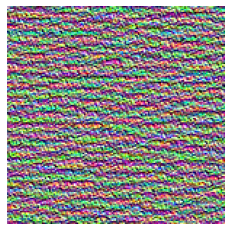

In [41]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

**Generating a grid of all filter response patterns in a layer**

In [42]:
all_images = []

for filter_index in range(64):

    print(f"Processing filter {filter_index}")
    image = deprocess_image(generate_filter_pattern(filter_index))
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

save_img(f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr